In [1]:
import sys
import os

from datetime import datetime, timedelta
from importlib import reload

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

#from hyperopt import hp, fmin, tpe, pyll
from scipy.interpolate import BSpline, splrep, splev


sys.path.append('../')
import src.model as model

plt.style.use("fivethirtyeight")

In [2]:
# import the datasets
mortality_df = pd.read_parquet('../data_clean/mortality.pq')
mobility_df = pd.read_parquet('../data_clean/mobility.pq')
cases_df = pd.read_parquet('../data_clean/cases.pq')

In [3]:
# convert date to datetime64 format
mortality_df["date"] = mortality_df["variable"].astype("datetime64")
mobility_df["date"] = mobility_df["date"].astype("datetime64")
cases_df["date"] = cases_df["variable"].astype("datetime64")

In [4]:
# forward fill na values
mortality_df["daily_deaths"] = mortality_df["value"].diff().fillna(mortality_df["value"])
cases_df['daily_cases'] = cases_df["value"].diff().fillna(cases_df["value"])

In [5]:
# merge mortality and mobilty dataframes on the date
merged_df = pd.merge(
    mortality_df, 
    mobility_df,
    how='left',
    left_on=['date'],
    right_on=['date']
)

In [6]:
# additionally merge cases on the previously merged dataframe
merged_df = pd.merge(
    merged_df,
    cases_df[['date', 'daily_cases']],
    how='left'
)

In [8]:
# estimate infections for each death using 0.4% infection fatality rate
merged_df['infections'] = merged_df['daily_deaths']/0.004

# smooth infections using rolling window of duration 7 days
merged_df['infections'] = merged_df['infections'].shift(-3, fill_value=0).rolling(7).mean()

# estimate infections from death using lag estimate from the link below
# https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/conditionsanddiseases/articles/coronaviruscovid19infectionsurveytechnicalarticle/wavesandlagsofcovid19inenglandjune2021/pdf
merged_df['infections'] = merged_df['infections'].shift(-19, fill_value=0)

In [12]:
# set date as the index
merged_df = merged_df.set_index('date')

In [13]:
# calculate ys_smooth which is a smooth fit to the infections
ys = np.array(merged_df['infections'])
ts = np.array(range(len(ys)))

# change this parameter to vary the smoothness of the fit
n_interior_knots = 30
qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
knots = np.quantile(ts, qs)
tck = splrep(ts, ys, t=knots, k=5)
ys_smooth = splev(ts, tck)


In [14]:
# add smoothed infections to the dataframe
merged_df['infections_smooth'] = ys_smooth

In [15]:
# fix the edge cases of the smoothed infection curve
merged_df.loc[np.logical_and(merged_df['infections']==0, np.logical_or(merged_df.index<'2020-04-01', merged_df.index>'2022-9-01')), 'infections_smooth'] = 0

In [17]:
# merged_df['avg_change_baseline'] = (merged_df['retail_and_recreation_percent_change_from_baseline'] + merged_df['transit_stations_percent_change_from_baseline'] + merged_df['workplaces_percent_change_from_baseline'])/3
# calculate moving average of retail, transit and workplace
merged_df['retail_ma'] = merged_df['retail_and_recreation_percent_change_from_baseline'].shift(-3, fill_value=0).rolling(7, min_periods=1).mean()
merged_df['transit_ma'] = merged_df['transit_stations_percent_change_from_baseline'].shift(-3, fill_value=0).rolling(7, min_periods=1).mean()
merged_df['workplace_ma'] = merged_df['workplaces_percent_change_from_baseline'].shift(-3, fill_value=0).rolling(7, min_periods=1).mean()

# average the three ma's calculated above
merged_df['avg_change_baseline_ma'] = (merged_df['retail_ma'] + merged_df['transit_ma'] + merged_df['workplace_ma'])/3

# further do an ma operation to smoothen the trend
merged_df['avg_change_baseline_ma'] = merged_df['avg_change_baseline_ma'].shift(-3, fill_value=0).rolling(7, min_periods=1).mean()

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

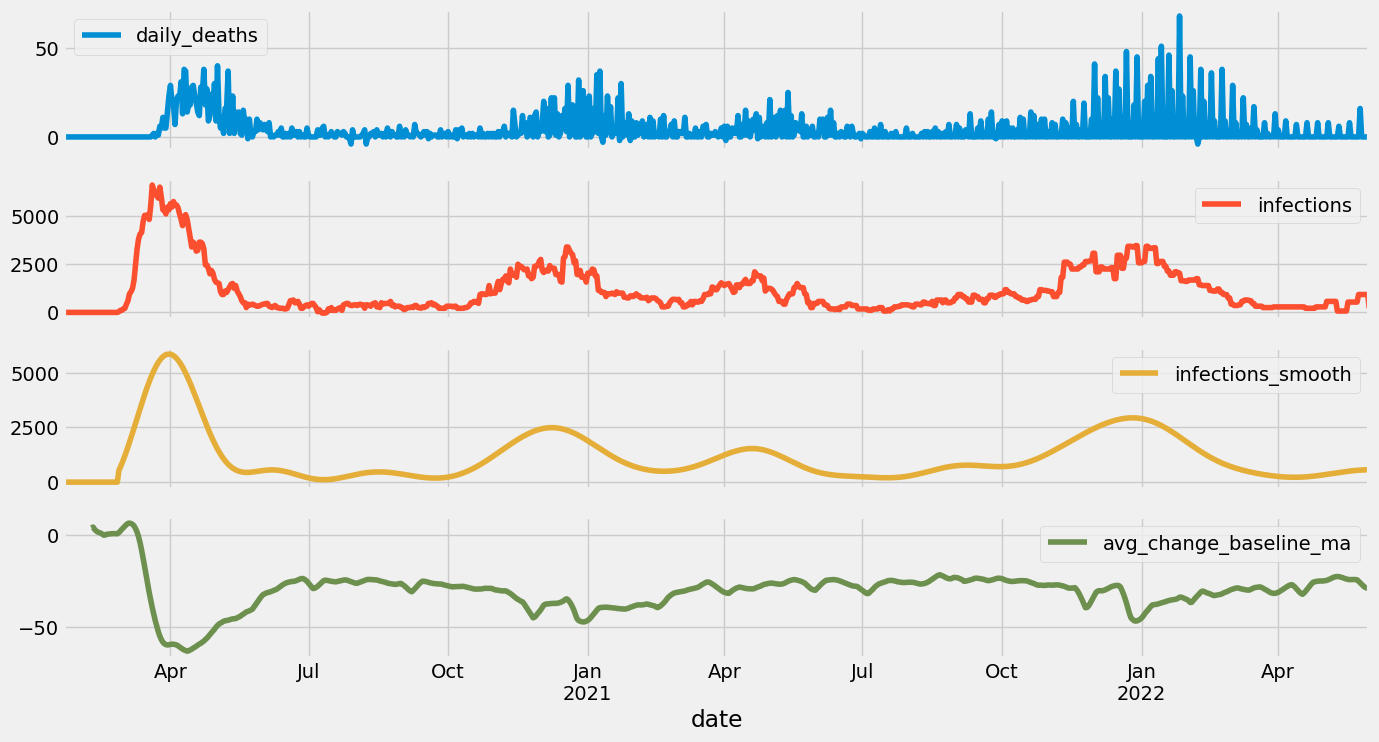

In [18]:
#merged_df[['infections_smooth', 'retail_and_recreation_percent_change_from_baseline']].plot(subplots=False, figsize=(12, 15))
# plot the deaths, estimated infections, smoothed infections and the average change in baseline in the mobility trends
merged_df[merged_df.index < '2022-06-01'][['daily_deaths', 'infections', 'infections_smooth', 'avg_change_baseline_ma']].plot(subplots=True, figsize=(15, 8))

In [19]:
# calculate infection growth rate and infection doubline rate
merged_df['infections_smooth_prev'] = merged_df['infections_smooth'].shift(1, fill_value=0)
merged_df['growth_rate'] = (merged_df['infections_smooth']/merged_df['infections_smooth_prev']).fillna(0)
merged_df['growth_rate'] = merged_df['growth_rate'].replace(np.inf, np.nan).fillna(method='bfill')

merged_df['doubling_rate'] = np.log(2)/np.log(merged_df['growth_rate'])

/home/abhishek/Documents/UW/DATA_512_Human_Centered_Data_Science/project/proj_env/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
# calculate durations where the wave was rising to get sample data points for our regression analysis
merged_df['wave_rise'] = np.logical_or.reduce((
    np.logical_and(merged_df.index>='2020-02-27', merged_df.index<='2020-03-02'),
    np.logical_and(merged_df.index>='2020-07-19', merged_df.index<='2020-07-23'),
    np.logical_and(merged_df.index>='2020-10-08', merged_df.index<='2020-10-13'),
    np.logical_and(merged_df.index>='2021-03-17', merged_df.index<='2021-03-18'),
    np.logical_and(merged_df.index>='2021-08-03', merged_df.index<='2021-08-08')
))

In [22]:
merged_df['wave_rise'] = merged_df['wave_rise'].apply(int)*6000

<AxesSubplot:xlabel='date'>

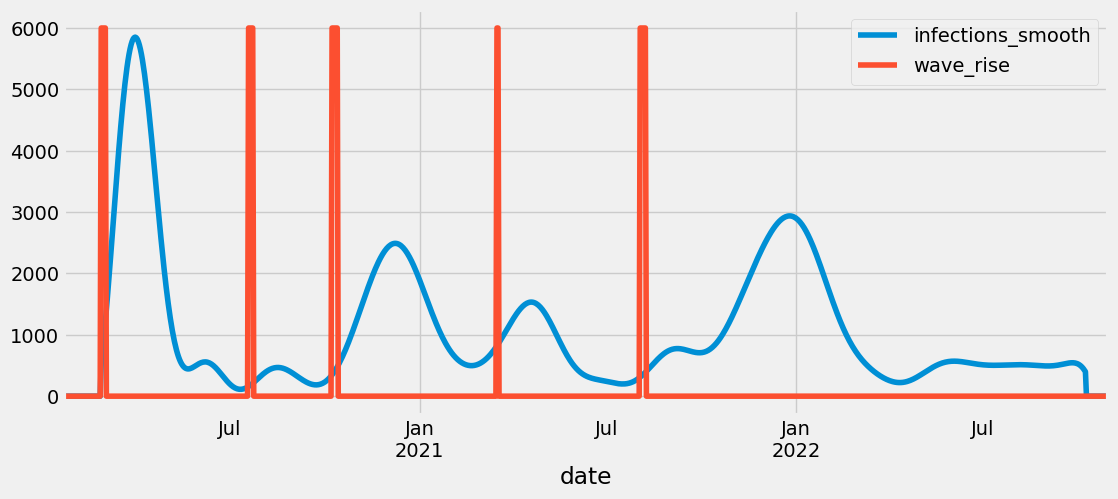

In [23]:
merged_df[['infections_smooth', 'wave_rise']].plot(subplots=False, figsize=(12, 5))

In [24]:
# filter data_df to the duration when the wave was rising
data_df = merged_df[merged_df['wave_rise']>0][['doubling_rate', 'avg_change_baseline_ma']]

In [25]:
data_df

,doubling_rate,avg_change_baseline_ma
date,,
2020-02-27,2.672631,1.489796
2020-02-28,2.672631,2.435374
2020-02-29,3.172149,3.319728
2020-03-01,3.666530,4.197279
2020-03-02,4.161489,5.088435
2020-07-19,10.162630,-25.387755
2020-07-20,9.912500,-25.170068
2020-07-21,9.843685,-25.006803
2020-07-22,9.914063,-24.802721


In [26]:
# define statistic to estimate using bootstrap
def calc_statistic(x, y):
    return stats.pearsonr(x, y)[0]


In [27]:
# calculate bootstrap confidence interval
bootstrap_ci = stats.bootstrap((data_df['avg_change_baseline_ma'], data_df['doubling_rate']), calc_statistic, vectorized=False, paired=True, random_state=1)

In [28]:
bootstrap_ci.confidence_interval

ConfidenceInterval(low=-0.8798855734313291, high=-0.4807138804207024)